In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import numpy as np
print(np.__version__)
import deepxde as dde
print(dde.backend)
import matplotlib.pyplot as plt
from scipy import io
import pandas as pd
import time
import mat73
import os
import csv

import torch


2.1.3
<module 'deepxde.backend' from '/home/users/jbi/anaconda3/envs/neural_networks_anpassungen_jb/lib/python3.12/site-packages/deepxde/backend/__init__.py'>


In [107]:
data = mat73.loadmat(r"/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/annular_P_v_IC_nl_data/annular_P_v_IC_vvar_10k_4k_20x.mat")

p_train = data["P_train"].astype(np.float32)
p_test = data["P_test"].astype(np.float32)

ic_train = data["IC_train"].astype(np.float32)
ic_test = data["IC_test"].astype(np.float32)

v_train = data["v_train"].astype(np.float32)
v_test = data["v_test"].astype(np.float32)

branch_train = np.concatenate([ic_train, v_train, p_train], axis=1)
branch_test = np.concatenate([ic_test, v_test, p_test], axis=1)

u_bias_train= data["U_bias_train"].astype(np.float32)
u_bias_test= data["U_bias_test"].astype(np.float32)
xyz_t_bias_train = data["xyz_t_bias_train"].astype(np.float32)
xyz_t_bias_test = data["xyz_t_bias_test"].astype(np.float32)

u_rd_train= data["U_rd_train"].astype(np.float32)
u_rd_test= data["U_rd_test"].astype(np.float32)
xyz_t_rd_train = data["xyz_t_rd_train"].astype(np.float32)
xyz_t_rd_test = data["xyz_t_rd_test"].astype(np.float32)

u_v_train= data["U_v_train"].astype(np.float32)
u_v_test= data["U_v_test"].astype(np.float32)
xyz_t_v_train = data["xyz_t_v_train"].astype(np.float32)
xyz_t_v_test = data["xyz_t_v_test"].astype(np.float32)

xyz_t_train = np.concatenate((xyz_t_bias_train, xyz_t_rd_train, xyz_t_v_train), axis=0)
xyz_t_test = np.concatenate((xyz_t_bias_test, xyz_t_rd_test, xyz_t_v_test), axis=0)

u_train = np.concatenate((u_bias_train, u_rd_train, u_v_train), axis=1)
u_test = np.concatenate((u_bias_test, u_rd_test, u_v_test), axis=1)

print(xyz_t_train.shape,ic_train.shape,p_train.shape,v_train.shape,branch_train.shape,u_train.shape)
print(xyz_t_test.shape,ic_test.shape,p_test.shape,v_test.shape,branch_test.shape,u_test.shape)

(6000, 4) (8000, 400) (8000, 20) (8000, 20) (8000, 440) (8000, 6000)
(6000, 4) (2000, 400) (2000, 20) (2000, 20) (2000, 440) (2000, 6000)


In [108]:
configs = []
id = 0


#n_train in (8000,800):
for neurons in (200,100,300):
    layers = 5 #for layers in (4,6):
    for act_IC in ("relu","swish"):
        for act_branch in ("relu","swish"):
                n_train = 8000
                act_trunk ="relu"# for act_trunk in ("relu","swish"):
                decay = "cosine"#for decay in ("None","cosine"):
                merge_operation = "mul" #for merge_operation in ("mul","add","cat"):
                output_merge_operation = "mul" #for merge_operation in ("mul","add","cat"):
                iterations = 100_000
                config = {
                    #"model_id": f"model_{model_id:04d}",
                    "n_train": n_train,
                    "iterations": iterations,
                    "neurons": neurons,
                    "layers": layers,
                    "activation IC": act_IC,
                    "activation Branch": act_branch,
                    "activation Trunk": act_trunk,
                    "merge_operation": merge_operation,
                    "output_merge_operation": output_merge_operation,
                    "decay": decay

                }
                configs.append(config)
                id += 1
                
print(configs[id-1])
print(id)

{'n_train': 8000, 'iterations': 100000, 'neurons': 300, 'layers': 5, 'activation IC': 'swish', 'activation Branch': 'swish', 'activation Trunk': 'relu', 'merge_operation': 'mul', 'output_merge_operation': 'mul', 'decay': 'cosine'}
12


In [109]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

output_path = r"/home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures"
output_path += r"/300_neurons"

title_add = " - 300 Neurons per Layer"

i = 8
print(configs[i])

{'n_train': 8000, 'iterations': 100000, 'neurons': 300, 'layers': 5, 'activation IC': 'relu', 'activation Branch': 'relu', 'activation Trunk': 'relu', 'merge_operation': 'mul', 'output_merge_operation': 'mul', 'decay': 'cosine'}


In [110]:
checkpoint = 100000

config = configs[i]
model_id = f"model_{i:02d}"
 # Modellverzeichnis
model_dir = f"/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/annular_P_v_IC_nl_models/Parameterstudien_vvar/P_v_IC_lin_V2/{model_id}"
os.makedirs(model_dir, exist_ok=True)

n_train = config["n_train"]
n_test = n_train//4

y_train = u_train[:n_train]
y_test = u_test[:n_test]

x_train = (ic_train[:n_train], v_train[:n_train], p_train[:n_train], xyz_t_train)
x_test = (ic_test[:n_test], v_test[:n_test], p_test[:n_test], xyz_t_test)

data = dde.data.QuintupleCartesianProd(x_train, y_train, x_test, y_test)

# Netzwerk
x1,x2,x3,x4 = 400,20,20,4

neurons = config["neurons"]
layers = config["layers"]
act_IC = config["activation IC"]
act_branch = config["activation Branch"]
act_trunk = config["activation Trunk"]
merge_operation = config["merge_operation"]
output_merge_operation = config["output_merge_operation"]
decay = config["decay"]

if merge_operation == "cat":
    b_neurons = int(neurons/2)
else:
    b_neurons = neurons

net = dde.nn.MIONetCartesianProd_3Branches(
                    [x1] + [neurons] * (layers-1) + [b_neurons], 
                    [x2] + [neurons] * (layers-1) + [b_neurons],
                    [x3] + [neurons] * (layers-1) + [b_neurons],
                    [x4] + [neurons] * layers, 
                    {"branch1":act_IC,"branch2":act_branch,"branch3":act_branch,"trunk":act_trunk}, 
                    "Glorot normal",
                    regularization=None,
                    merge_operation=merge_operation,
                    output_merge_operation=output_merge_operation
                )

start_time = time.time()

model = dde.Model(data, net)

if decay == "cosine":
    model.compile("adam", lr=1e-3, metrics=["mean l2 relative error"],decay=("cosine", 100_000, 0))
else:
    model.compile("adam", lr=1e-3, metrics=["mean l2 relative error"])

os.makedirs(f"{model_dir}/checkpoints", exist_ok=True)
checker = dde.callbacks.ModelCheckpoint(
f"{model_dir}/checkpoints/model", save_better_only=True, period=10000
)


model.train(iterations=0)

if checkpoint == 100000:
    model.restore(f"{model_dir}/model-100000.pt")#,device="cpu")
else:
    model.restore(f"{model_dir}/checkpoints/model-{checkpoint}.pt")
    print(f"Loaded model {i} at checkpoint {checkpoint}")

Compiling model...
'compile' took 0.000197 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.22e+06]    [4.18e+06]    [9.99e-01]    

Best model at step 0:
  train loss: 4.22e+06
  test loss: 4.18e+06
  test metric: [9.99e-01]

'train' took 0.146472 s



In [111]:
data = mat73.loadmat(r"/home/users/jbi/Bachelorarbeit/Codebase/Netze/MIONet/annular_P_v_IC_nl_data/annular_lin_val_20%.mat")

p_val = data["P_val"].astype(np.float32)

ic_val = data["IC_val"].astype(np.float32)

v_val = data["v_val"].astype(np.float32)


u_val= data["U_val"].astype(np.float32)
u_val= data["U_val"].astype(np.float32)
xyz_t_val = data["xyz_t_val"].astype(np.float32)
xyz_t_val = data["xyz_t_val"].astype(np.float32)



print(xyz_t_val.shape,ic_val.shape,p_val.shape,v_val.shape,u_val.shape)

(84000, 4) (100, 400) (100, 20) (100, 20) (100, 84000)


In [112]:
ic_val2 = np.zeros((2000,400))
v_val2 = np.zeros((2000,20))
p_val2 = np.zeros((2000,20))



for i in range(20):
    fak = 0.6 + 0.8*np.random.random(1)[0]
    ic_val2[i*100:i*100+100,:] = fak*ic_val
    v_val2[i*100:i*100+100,:]= fak*v_val
    p_val2[i*100:i*100+100,:]= fak*p_val




# Analyse der Runtime

In [113]:
# Create dummy data if not already present
try:
    _ = model
    _ = ic_val, v_val, p_val, xyz_t_val
except NameError:
    print("WARNING: Using dummy data for demonstration. Please ensure your actual data and model are available.")
    # Dummy data for demonstration purposes
    model = lambda x: np.zeros((x[0].shape[0], x[3].shape[1], 1))
    ic_val = np.random.rand(100, 20 * 20 * 10)
    v_val = np.random.rand(100, 20)
    p_val = np.random.rand(100, 20)
    xyz_t_val = np.random.rand(1, 84000, 4)

In [114]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- ASSUMPTIONS ---
# This script assumes you have the following objects available in your environment:
# - model: The pre-trained neural network model.
# - ic_val, v_val, p_val: Input data arrays for samples.
# - xyz_t_val: The time-space coordinate array for points.
# The script will use dummy data if these are not defined to ensure it runs.

# Create dummy data if not already present
try:
    _ = model
    _ = ic_val, v_val, p_val, xyz_t_val
except NameError:
    print("WARNING: Using dummy data for demonstration. Please ensure your actual data and model are available.")
    # Dummy data for demonstration purposes
    model = lambda x: np.zeros((x[0].shape[0], x[3].shape[1], 1))
    ic_val = np.random.rand(100, 20 * 20 * 10)
    v_val = np.random.rand(100, 20)
    p_val = np.random.rand(100, 20)
    xyz_t_val = np.random.rand(1, 84000, 4)


# --- CONFIGURATION ---
# Define the number of samples and points to test, as requested.
samples_to_test = [1, 5, 20, 100, 500, 2000]
points_to_test = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 84000]
NUM_RUNS = 100  # Number of times to run the prediction for averaging

# --- RUNTIME ANALYSIS ---
print("Starting runtime analysis...")
runtime_data = []
i = 1
x_val = (ic_val2[i].reshape(1, -1), v_val2[i].reshape(1, -1), p_val2[i].reshape(1, -1), xyz_t_val)
u_pred = model.predict(x_val)

# Outer loop for number of samples
for num_samples in samples_to_test:
    # Inner loop for number of points
    for num_points in points_to_test:
        total_time = 0

        try:
            # Select the requested number of samples from the input data
            # Reshaping is necessary to match the input format of your model's predict function
            ic_slice = ic_val2[:num_samples]
            v_slice = v_val2[:num_samples]
            p_slice = p_val2[:num_samples]
            
            # Select the requested number of points from the coordinate array
            xyz_t_slice = xyz_t_val[:num_points, :]
            
            # Create the input tuple for the model
            if num_samples == 1:
                x_val = (ic_val2[i].reshape(1, -1), v_val2[i].reshape(1, -1), p_val2[i].reshape(1, -1), xyz_t_slice)
            else:
                x_val = (ic_slice, v_slice, p_slice, xyz_t_slice)

            for _ in range(NUM_RUNS):
                start_time = time.time()
                
                # Perform a single prediction on the dataset
                u_pred = model.predict(x_val)
                end_time = time.time()

                total_time += (end_time - start_time)
            
            # Calculate the average runtime
            average_time = total_time / NUM_RUNS
            runtime_data.append({
                'Samples': num_samples,
                'Points': num_points,
                'Runtime (s)': average_time
            })
            print(f"SAMPLES: {num_samples:<3} | POINTS: {num_points:<6} | RUNTIME: {average_time:.4f} s")
            
        except Exception as e:
            print(f"Error during prediction for Samples={num_samples}, Points={num_points}: {e}")
            runtime_data.append({
                'Samples': num_samples,
                'Points': num_points,
                'Runtime (s)': np.nan  # Use NaN for failed runs
            })

# --- DATA PRESENTATION ---
# Create a DataFrame from the collected data for a clear table view
runtime_df = pd.DataFrame(runtime_data)

print("\n--- Runtime Data Table ---")
# Pivot the table to show samples as rows and points as columns for easy comparison
pivot_df = runtime_df.pivot(index='Samples', columns='Points', values='Runtime (s)')
print(pivot_df.to_string())

Starting runtime analysis...
SAMPLES: 1   | POINTS: 1      | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 2      | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 4      | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 8      | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 16     | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 32     | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 64     | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 128    | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 256    | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 512    | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 1024   | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 2048   | RUNTIME: 0.0009 s
SAMPLES: 1   | POINTS: 4096   | RUNTIME: 0.0012 s
SAMPLES: 1   | POINTS: 8192   | RUNTIME: 0.0016 s
SAMPLES: 1   | POINTS: 16384  | RUNTIME: 0.0026 s
SAMPLES: 1   | POINTS: 32768  | RUNTIME: 0.0054 s
SAMPLES: 1   | POINTS: 65536  | RUNTIME: 0.0095 s
SAMPLES: 1   | POINTS: 84000  | RUNTIME: 0.0114 s
SAMPLES: 5   | POINTS: 1      | RUNTIME: 0.0006 s
SAMPLES: 5   | POINTS


--- Generating 2D Line Plot ---


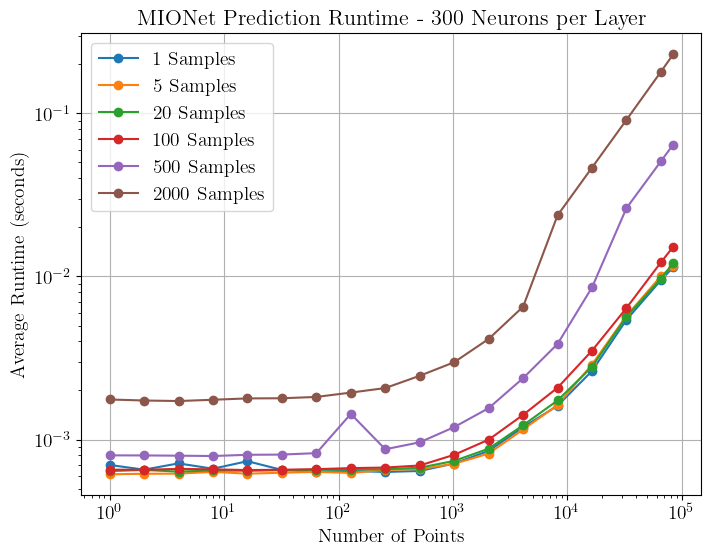

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/300_neurons_runtime.pdf


In [115]:
# --- PLOTTING ---
print("\n--- Generating 2D Line Plot ---")
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate through each unique number of samples and plot a line
for num_samples in sorted(samples_to_test):
    # Filter the data for the current number of samples
    df_slice = runtime_df[runtime_df['Samples'] == num_samples]
    ax.plot(df_slice['Points'], df_slice['Runtime (s)'], label=f'{num_samples} Samples', marker='o')

# Set both axes to a logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set axis labels and title with specified font sizes
ax.set_xlabel('Number of Points', fontsize=14)
ax.set_ylabel('Average Runtime (seconds)', fontsize=14)
ax.set_title(f'MIONet Prediction Runtime'+title_add, fontsize=16)
ax.legend(prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True)

# Save to file
save_path = output_path+r"_runtime.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")

In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- ASSUMPTIONS ---
# This script assumes you have the following objects available in your environment:
# - model: The pre-trained neural network model.
# - ic_val, v_val, p_val: Input data arrays for samples.
# - xyz_t_val: The time-space coordinate array for points.
# The script will use dummy data if these are not defined to ensure it runs.

# Create dummy data if not already present
try:
    _ = model
    _ = ic_val, v_val, p_val, xyz_t_val
except NameError:
    print("WARNING: Using dummy data for demonstration. Please ensure your actual data and model are available.")
    # Dummy data for demonstration purposes
    model = lambda x: np.zeros((x[0].shape[0], x[3].shape[1], 1))
    ic_val = np.random.rand(100, 20 * 20 * 10)
    v_val = np.random.rand(100, 20)
    p_val = np.random.rand(100, 20)
    xyz_t_val = np.random.rand(1, 84000, 4)


# --- CONFIGURATION ---
# Define the number of samples and points to test, as requested.
samples_to_test = [1, 5, 20, 100, 500, 2000]
points_to_test = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 84000]
NUM_RUNS = 100  # Number of times to run the prediction for averaging

# --- RUNTIME ANALYSIS ---
print("Starting runtime analysis...")
runtime_data = []
i = 1
x_val = (ic_val2[i].reshape(1, -1), v_val2[i].reshape(1, -1), p_val2[i].reshape(1, -1), xyz_t_val)
u_pred = model.predict(x_val)

# Outer loop for number of samples
for num_samples in samples_to_test:
    # Inner loop for number of points
    for num_points in points_to_test:
        total_time = 0

        try:
            # Select the requested number of samples from the input data
            # Reshaping is necessary to match the input format of your model's predict function
            ic_slice = ic_val2[:num_samples]
            v_slice = v_val2[:num_samples]
            p_slice = p_val2[:num_samples]
            
            # Select the requested number of points from the coordinate array
            xyz_t_slice = xyz_t_val[:num_points, :]
            
            # Create the input tuple for the model
            if num_samples == 1:
                x_val = (ic_val2[i].reshape(1, -1), v_val2[i].reshape(1, -1), p_val2[i].reshape(1, -1), xyz_t_slice)
            else:
                x_val = (ic_slice, v_slice, p_slice, xyz_t_slice)

            for _ in range(NUM_RUNS):
                start_time = time.time()
                
                # Perform a single prediction on the dataset
                u_pred = model.predict(x_val)

                if num_points < 16:
                    u_pred_2 = u_pred.reshape((num_samples,num_points))
                elif num_points < 16**2:
                    u_pred_2 = u_pred.reshape((num_samples,16,num_points//16))
                elif num_points < 16**3:
                    u_pred_2 = u_pred.reshape((num_samples,16,16,num_points//(16**2)))                 
                elif num_points < 16**4:
                    u_pred_2 = u_pred.reshape((num_samples,16,16,16,num_points//(16**3)))
                elif num_points == 84000:
                    u_pred_2 = u_pred.reshape((num_samples,20,20,10,21))

                end_time = time.time()

                total_time += (end_time - start_time)
            
            # Calculate the average runtime
            average_time = total_time / NUM_RUNS
            runtime_data.append({
                'Samples': num_samples,
                'Points': num_points,
                'Runtime (s)': average_time
            })
            print(f"SAMPLES: {num_samples:<3} | POINTS: {num_points:<6} | RUNTIME: {average_time:.4f} s")
            
        except Exception as e:
            print(f"Error during prediction for Samples={num_samples}, Points={num_points}: {e}")
            runtime_data.append({
                'Samples': num_samples,
                'Points': num_points,
                'Runtime (s)': np.nan  # Use NaN for failed runs
            })

# --- DATA PRESENTATION ---
# Create a DataFrame from the collected data for a clear table view
runtime_df = pd.DataFrame(runtime_data)

print("\n--- Runtime Data Table ---")
# Pivot the table to show samples as rows and points as columns for easy comparison
pivot_df = runtime_df.pivot(index='Samples', columns='Points', values='Runtime (s)')
print(pivot_df.to_string())


# Save to file
save_path = output_path+r"_runtime_reshape_data.csv"


print(f"Neural network diagram saved to: {save_path}")

Starting runtime analysis...
SAMPLES: 1   | POINTS: 1      | RUNTIME: 0.0008 s
SAMPLES: 1   | POINTS: 2      | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 4      | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 8      | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 16     | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 32     | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 64     | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 128    | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 256    | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 512    | RUNTIME: 0.0006 s
SAMPLES: 1   | POINTS: 1024   | RUNTIME: 0.0007 s
SAMPLES: 1   | POINTS: 2048   | RUNTIME: 0.0008 s
SAMPLES: 1   | POINTS: 4096   | RUNTIME: 0.0012 s
SAMPLES: 1   | POINTS: 8192   | RUNTIME: 0.0016 s
SAMPLES: 1   | POINTS: 16384  | RUNTIME: 0.0033 s
SAMPLES: 1   | POINTS: 32768  | RUNTIME: 0.0052 s
SAMPLES: 1   | POINTS: 65536  | RUNTIME: 0.0093 s
SAMPLES: 1   | POINTS: 84000  | RUNTIME: 0.0114 s
SAMPLES: 5   | POINTS: 1      | RUNTIME: 0.0006 s
SAMPLES: 5   | POINTS


--- Generating 2D Line Plot ---


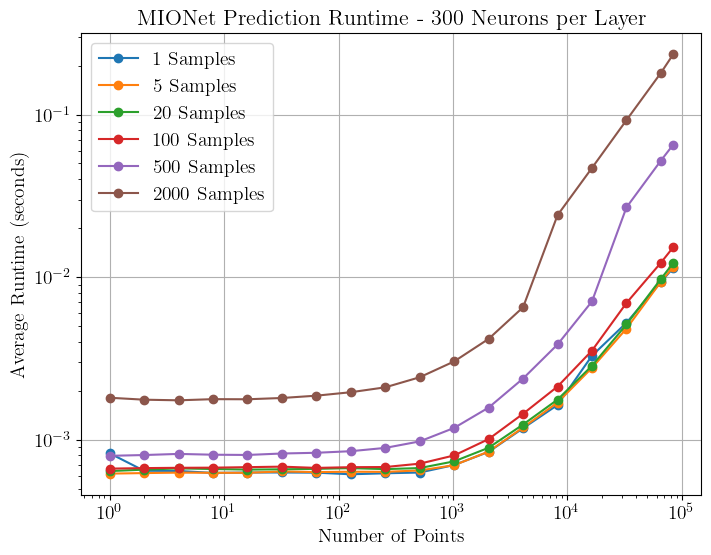

Neural network diagram saved to: /home/users/jbi/Bachelorarbeit/Codebase/Genauigkeit/figures/300_neurons_runtime_reshape.pdf


In [117]:
# --- PLOTTING ---
print("\n--- Generating 2D Line Plot ---")
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate through each unique number of samples and plot a line
for num_samples in sorted(samples_to_test):
    # Filter the data for the current number of samples
    df_slice = runtime_df[runtime_df['Samples'] == num_samples]
    ax.plot(df_slice['Points'], df_slice['Runtime (s)'], label=f'{num_samples} Samples', marker='o')

# Set both axes to a logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set axis labels and title with specified font sizes
ax.set_xlabel('Number of Points', fontsize=14)
ax.set_ylabel('Average Runtime (seconds)', fontsize=14)
ax.set_title(f'MIONet Prediction Runtime'+title_add, fontsize=16)
ax.legend(prop={'size': 14})
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True)

# Save to file
save_path = output_path+r"_runtime_reshape.pdf"
plt.savefig(save_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Neural network diagram saved to: {save_path}")